In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # Visualization
import plotly.express as px # Visualization
import seaborn as sns # Visualization
import pickle # Save model files

# Libraries for model building
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input

# For Evalution we will use these library

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
# import csv file
df = pd.read_csv('/Users/kittipot/Desktop/Bitcoin_data/btcusd_1-min_data.csv')

In [3]:
# Exploring data analysis in dataframe

# Check Head of DataFrame
print(df.head())

# Check missing value in data
print(df.isnull().sum())
# check data info
print(df.info())

# Convert unix timestamp To datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

# Convert to Y-m-d format
df['Timestamp'] = df['Timestamp'].dt.strftime('%Y-%m-%d')
print(df['Timestamp'])

# Set timestamp Column to be index
df.set_index('Timestamp', inplace=True)

# Convert Scientific Notation output to Float
pd.options.display.float_format = '{:.2f}'.format

# Visualize data stat
print((df.describe()))

      Timestamp  Open  High   Low  Close  Volume
0  1.325412e+09  4.58  4.58  4.58   4.58     0.0
1  1.325412e+09  4.58  4.58  4.58   4.58     0.0
2  1.325412e+09  4.58  4.58  4.58   4.58     0.0
3  1.325412e+09  4.58  4.58  4.58   4.58     0.0
4  1.325412e+09  4.58  4.58  4.58   4.58     0.0
Timestamp    1
Open         0
High         0
Low          0
Close        0
Volume       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6729281 entries, 0 to 6729280
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Timestamp  float64
 1   Open       float64
 2   High       float64
 3   Low        float64
 4   Close      float64
 5   Volume     float64
dtypes: float64(6)
memory usage: 308.0 MB
None
0          2012-01-01
1          2012-01-01
2          2012-01-01
3          2012-01-01
4          2012-01-01
              ...    
6729276    2024-12-15
6729277    2024-12-15
6729278    2024-12-15
6729279    2024-12-16
6729280           NaN
Name: Time

In [ ]:
# Draw box plot To Visualize distribution in each columns
cols = df[['Open', 'High', 'Low', 'Close', 'Volume']]

for col in cols.columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=cols[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

In [ ]:
cols_2 = df[['Open', 'High', 'Low', 'Close', 'Volume']]

# Create histogram to Visualize distribution in each column
for col in cols_2.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(cols_2[col], kde=True, bins=100, color='blue')  # histogram + density
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()
    plt.show()

In [7]:
# In This Project We Will Use Data Between 2021-2022 To Predict Bitcoin Price In 2023

# Split Data Into train & test data
train_data = df['2021-01-01':'2022-12-31']  # Training data
test_data = df['2023-01-01': '2023-12-31']  # Testing data

# Inspect Data Type
print(f"Training Data Shape: {train_data.shape}")
print(f"Testing Data Shape: {test_data.shape}")

# Normalize Data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[['Open', 'High', 'Low', 'Close',
                                    'Volume']])  # Fit Only Training Set 
test_scaled = scaler.transform(test_data[['Open', 'High', 'Low', 'Close',
                                    'Volume']])
# Inspect Output
print(train_scaled.shape)
print(test_scaled.shape)

Training Data Shape: (1051080, 5)
Testing Data Shape: (525540, 5)
(1051080, 5)
(525540, 5)


การ fit เฉพาะชุดข้อมูล training set (ชุดข้อมูลที่ใช้ฝึกโมเดล) ในกระบวนการทำ Normalization หรือ Scaling มีเหตุผลสำคัญด้านความถูกต้องของการวิเคราะห์และการป้องกัน data leakage ดังนี้:1. ป้องกัน Data Leakage
การ fit กับทั้งชุดข้อมูล (รวมทั้ง training และ test set) อาจทำให้ข้อมูลจาก test set ซึ่งควรถูกใช้เพียงเพื่อการประเมินผลลัพธ์ของโมเดล ถูกเปิดเผยระหว่างการฝึกโมเดล
การเปิดเผยข้อมูลล่วงหน้า (data leakage) ทำให้โมเดลได้รับข้อมูลที่ไม่ควรรู้ก่อนการทดสอบ ซึ่งส่งผลต่อความแม่นยำที่ไม่สะท้อนความสามารถที่แท้จริงของโมเดลในสถานการณ์จริง
2. จำลองสถานการณ์จริง
ในการใช้งานจริง โมเดลจะต้องประมวลผลข้อมูลใหม่ที่ไม่เคยเห็นมาก่อน (เหมือน test set) โดยใช้ค่าพารามิเตอร์ที่ได้จากข้อมูลในอดีต (training set)
การ fit เฉพาะ training set แล้วใช้ค่าพารามิเตอร์ที่ได้ (เช่น ค่า min และ max จาก MinMaxScaler) ไป transform test set จึงเลียนแบบสถานการณ์จริงได้ดีที่สุด
3. สอดคล้องกับแนวคิด Machine Learning Pipeline
การฝึก (training) และการทดสอบ (testing) เป็นขั้นตอนที่แยกจากกันโดยชัดเจน
พารามิเตอร์ที่ได้จากการปรับสเกล (scaling) เช่น ค่า min และ max หรือค่าเฉลี่ย (mean) และส่วนเบี่ยงเบนมาตรฐาน (std) ควรมาจาก training set เท่านั้น เพื่อให้ pipeline ถูกต้อง

In [10]:
# Convert Data To DataFrame
train_scaled = pd.DataFrame(train_scaled, columns=train_data.columns, index=train_data.index)
test_scaled = pd.DataFrame(test_scaled, columns=test_data.columns, index=test_data.index)

In [ ]:
train_scaled_col = train_scaled.iloc[:, 0:5]

# Visualize distribution in each column after normalization
for col in train_scaled_col.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(train_scaled_col[col], kde=True, bins=100, color='blue')  # histogram + density
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()
    plt.show()

In [ ]:
test_scaled_col = test_scaled.iloc[:, 0:5]

# Visualize distribution in each column
for col in test_scaled_col.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(test_scaled_col[col], kde=True, bins=100, color='blue')  # histogram + density
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()
    plt.show()

ต่อไป เราจะเขียนฟังก์ชัน create sliding_window function เพื่อแปลงข้อมูลให้เป็น3มิติเพื่อเตรียมใช้กับ LSTM Model
ตัวแปร X เป็น Input สำหรับโมเดล ซึ่งประกอบด้วยช่วงข้อมูลในอดีตตามจำนวน timesteps ที่กำหนด
แต่ละรายการใน X มีลักษณะเป็นกลุ่มข้อมูลที่มีความยาว timesteps และข้อมูลในทุกคอลัมน์ของ data
ตัวแปร y เป็น Target (Output) ที่โมเดลต้องทำนาย
สำหรับแต่ละรายการใน X ค่าใน y จะเป็นข้อมูลในคอลัมน์ที่ระบุด้วย target_col_idx ของตำแหน่งถัดไปจากช่วงข้อมูลใน X
ส่งค่ากลับไปในตัวแปร X, y 
X: sliding window สำหรับ features
y: ค่าTarget สำหรับแต่ละ window

ในที่นี้เราจะใช้ ['Close'] ทั้งใน Features และ Target เนื่องจาก
1.Time Series Forecasting: ต้องการพยากรณ์ราคาปิด (Close) ของช่วงเวลาถัดไป โดยอิงจากข้อมูลราคา Close ในอดีต
2.กรณีโมเดลได้รับลำดับเวลา (sequence): เช่น การใช้ LSTM หรือ RNN ที่สามารถจับความสัมพันธ์ของข้อมูลในอดีตได้

In [12]:
# Create Function To Transform Data

def create_sliding_window(data, target_col_idx, timesteps):
    # Create Input X using numpy indexing
    X = np.array([data[i:i + timesteps, :] for i in range(len(data) - timesteps)])
    # Create Output y using target_col_idx
    y = np.array([data[i + timesteps, target_col_idx] for i in range(len(data) - timesteps)])
    return X, y

# Transform DataFrame To numpy array
train_array = train_scaled.values
test_array = test_scaled.values

# Assign Timestep
timesteps = 30

# Assign index from Target column
target_col_idx = train_scaled.columns.get_loc('Close')

# Create Sliding Window
X_train, y_train = create_sliding_window(train_array, target_col_idx, timesteps)
X_test, y_test = create_sliding_window(test_array, target_col_idx, timesteps)

# Inspect Data Shape
print("X_train shape:", X_train.shape)  # (samples, timesteps, features)
print("y_train shape:", y_train.shape)  # (samples,)
print("X_test shape:", X_test.shape)    # (samples, timesteps, features)
print("y_test shape:", y_test.shape)    # (samples,)

# Inspect Sliding Window ที่ 10
window_idx = 10
print(f"X_train[{window_idx}]:\n", X_train[window_idx])
print(f"y_train[{window_idx}]:", y_train[window_idx])


X_train shape: (1051050, 30, 5)
y_train shape: (1051050,)
X_test shape: (525510, 30, 5)
y_test shape: (525510,)
X_train[10]:
 [[0.24999533 0.24983827 0.25083424 0.24988916 0.01990488]
 [0.24992336 0.25021633 0.25115625 0.25019738 0.00957224]
 [0.25019738 0.25004506 0.25118345 0.25018467 0.00886467]
 [0.25027234 0.25040068 0.25133161 0.25009813 0.04978637]
 [0.25009813 0.25006824 0.25025248 0.24934579 0.01377948]
 [0.2490785  0.24991755 0.25030856 0.25014187 0.00458931]
 [0.24990654 0.25001907 0.25079167 0.24992299 0.01245438]
 [0.2500185  0.25073274 0.25125171 0.25093645 0.02230753]
 [0.25082467 0.25117792 0.25188261 0.25108953 0.02892907]
 [0.25112    0.25126019 0.25225207 0.25101551 0.00112928]
 [0.25119028 0.25164535 0.25239329 0.25186916 0.00285393]
 [0.25176841 0.25178446 0.25278488 0.25177664 0.01214086]
 [0.25200822 0.25192151 0.25289515 0.25191495 0.01225006]
 [0.25191495 0.2519217  0.2527845  0.25201439 0.00230961]
 [0.25176729 0.25190019 0.25285389 0.25177551 0.00202282]
 [0.

window_idx = 10
print(f"X_train[{window_idx}]:\n", X_train[window_idx])
print(f"y_train[{window_idx}]:", y_train[window_idx])

แสดงข้อมูล(Feature)ใน sliding window ที่ 10 (X_train[10]) และค่าTargetที่สอดคล้อง (y_train[10])

In [15]:
# Inspect timesteps and features From X_train
timesteps = X_train.shape[1]  # Amount of timestep
features = X_train.shape[2]   # Amount of features
print("Timesteps:", timesteps)
print("Features:", features)

Timesteps: 30
Features: 5


In [ ]:
# Create a sequential model
model=Sequential()

# Add LSTM Layer
model.add(Input(shape=(timesteps, features)))
model.add(LSTM(64, activation="relu"))

# Add Dense layer For Forecast Output (Ex. Close Price)
model.add(Dense(1))

# Compile the model
model.compile(loss="mean_squared_error",optimizer="adam")

# Train the model
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=3,batch_size=32,verbose=1)

In [ ]:
# Save model that already train
model.save('/Users/kittipot/Desktop/Machine Learning Files/LSTM_Bitcoins_Predict.keras')  # Save as keras

In [17]:
# Load model
model = load_model('/Users/kittipot/Desktop/Machine Learning Files/LSTM_Bitcoins_Predict.keras')

In [ ]:
# Save model loss/validation loss to use next time
# Save history data
history_path = '/Users/kittipot/Desktop/Machine Learning Files/history.pkl'
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)

In [19]:
# Load model loss/validation loss
# Load history data
history_path = '/Users/kittipot/Desktop/Machine Learning Files/history.pkl'
with open(history_path, 'rb') as f:
    loaded_history = pickle.load(f)

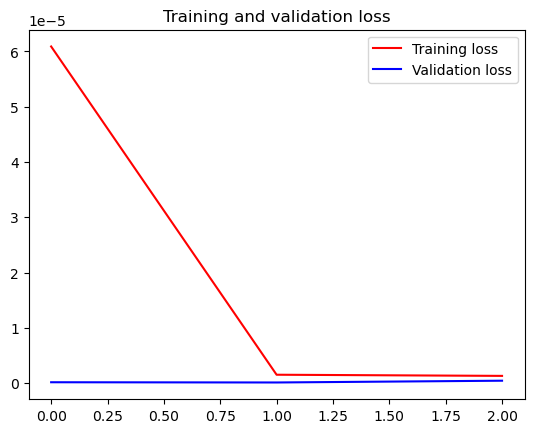

<Figure size 640x480 with 0 Axes>

In [21]:
# Visualize Training loss VS Validation loss During Train Process

"""loss = history.history['loss']
val_loss = history.history['val_loss']"""

loss = loaded_history['loss'] # In case of loading the history file, use this code
val_loss = loaded_history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [23]:
# Lets Do the prediction and check performance metrics
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict.shape, test_predict.shape

32846/32846 ━━━━━━━━━━━━━━━━━━━━ 43s 1ms/step
16423/16423 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step


((1051050, 1), (525510, 1))

In [25]:
print(train_predict)
print(test_predict)

[[0.25134978]
 [0.2518062 ]
 [0.2519941 ]
 ...
 [0.01946659]
 [0.01945893]
 [0.01945375]]
[[0.01939788]
 [0.01939763]
 [0.01939069]
 ...
 [0.5060517 ]
 [0.50628847]
 [0.5065417 ]]


In [27]:
print(y_train.shape)
print(y_test.shape)
print(y_train)
print(y_test)

(1051050,)
(525510,)
[0.25252935 0.25265813 0.25268374 ... 0.01994393 0.01994393 0.01994393]
[0.01988785 0.01988785 0.01988785 ... 0.50706542 0.50725234 0.50727103]


In [31]:
# Create scaler For Target
scaler_target = MinMaxScaler()

# Transform Target
scaled_target = scaler_target.fit_transform(train_data[['Close']])  # Keep transform data in scaled_target variable 

# Transform back to original form
train_predict = scaler_target.inverse_transform(train_predict)
test_predict = scaler_target.inverse_transform(test_predict)
original_ytrain = scaler_target.inverse_transform(y_train.reshape(-1, 1)) 
original_ytest = scaler_target.inverse_transform(y_test.reshape(-1, 1))

print("Transformed Back to Original Scale!")
print(test_predict)

Transformed Back to Original Scale!
[[16537.785]
 [16537.773]
 [16537.402]
 ...
 [42573.77 ]
 [42586.434]
 [42599.984]]


เราต้องแยกตัวแปรสำหรับข้อมูลที่ถูกสเกล (scaled_target) และตัวแปรที่เป็น MinMaxScaler (scaler_target) ออกจากกัน เพื่อให้ scaler_target ยังคงเป็นตัวแปรที่เก็บออบเจ็กต์ MinMaxScaler ไว้สำหรับการใช้งาน inverse_transform ในภายหลัง

ตัวแปร scaler_target:
เก็บวัตถุ MinMaxScaler ที่ผ่านการเรียนรู้ขอบเขต (min, max) ของข้อมูลใน train_data[['Close']] เพื่อใช้งาน transform และ inverse_transform
ตัวแปร scaled_target:
เก็บข้อมูลที่ถูกสเกลไว้สำหรับการใช้งานในภายหลัง (เช่น การฝึกโมเดล) โดยไม่กระทบกับการใช้งาน scaler_target

การ fit ด้วยข้อมูล test อาจทำให้เกิดปัญหาข้อมูลรั่วไหล (data leakage) ซึ่งส่งผลต่อความน่าเชื่อถือของการประเมินโมเดล.

ใช้ fit เฉพาะกับ train data:
ให้แน่ใจว่า MinMaxScaler ถูก fit ด้วยข้อมูลชุด train เท่านั้น และใช้ transform กับข้อมูลชุด test.

In [33]:
# Evaluation metrices RMSE, MSE and MAE
print("Train data RMSE: ", np.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", np.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  59.50732183586459
Train data MSE:  3541.1213520771666
Train data MAE:  44.21762417742228
-------------------------------------------------------------------------------------
Test data RMSE:  35.47020849478329
Test data MSE:  1258.1356906633969
Test data MAE:  31.580450397292626


ต่อไปเราจะทำการเปรียบเทียบราคาปิดจริงกับราคาปิดที่โมเดลทำนายได้

In [36]:
# Inspect length of each 
print("Length of train_predict:", len(train_predict.flatten()))
print("Length of test_predict:", len(test_predict.flatten()))
print("Length of train_data:", len(train_data))
print("Length of test_data:", len(test_data))

Length of train_predict: 1051050
Length of test_predict: 525510
Length of train_data: 1051080
Length of test_data: 525540


1.เหตุผลที่ข้อมูลเหลื่อมกัน:
ข้อมูล train_predict และ test_predict จะเริ่มต้นหลังจาก timesteps ตัวแรกของ train_data และ test_data เพราะข้อมูลเริ่มต้น timesteps ถูกใช้เพื่อสร้าง input sequence (X_train และ X_test) และไม่มีการทำนายสำหรับตำแหน่งเหล่านั้น
ดังนั้น train_predict และ test_predict จะมีขนาดน้อยกว่าข้อมูลต้นฉบับ (train_data และ test_data) เท่ากับจำนวน timesteps ที่คุณกำหนดไว้
2.การแก้ปัญหา: เราต้องปรับข้อมูล train_data และ test_data ให้สอดคล้องกับ train_predict และ test_predict โดยลบ timesteps แรกออกจาก train_data และ test_data ก่อนการเปรียบเทียบ:

In [ ]:
# Adjust train_data และ test_data ตาม timesteps
adjusted_train_data = train_data.iloc[timesteps:]
adjusted_test_data = test_data.iloc[timesteps:]

# inspect interest data range
start_date = '2023-01-01'
end_date = '2023-12-31'

# filter data according to interest data range
focused_train_data = adjusted_train_data.loc[start_date:end_date]
focused_test_data = adjusted_test_data.loc[start_date:end_date]

# Create DataFrame to concatenate data
focused_plotdf = pd.DataFrame({
    'date': pd.concat([focused_train_data.index.to_series(), focused_test_data.index.to_series()]),
    'original_close': pd.concat([focused_train_data['Close'], focused_test_data['Close']]),
    'predicted_close': np.concatenate([
        train_predict[:len(focused_train_data)].flatten(),
        test_predict[:len(focused_test_data)].flatten()
    ])
})

# Create graph to comparison
fig = px.line(
    focused_plotdf,
    x='date',
    y=['original_close', 'predicted_close'],
    labels={'value': 'Stock price', 'date': 'Date'}
)
fig.update_layout(
    title_text='Comparison of Original Close Price vs Predicted Close Price (Focused)',
    plot_bgcolor='white',
    font_size=15,
    font_color='black',
    legend_title_text='Close Price'
)
fig.show()


In [39]:
# Use last 30th days data from test_data (according timesteps we use to train model)
last_known_data = test_data[['Close', 'Open', 'High', 'Low', 'Volume']].iloc[-30:].values # Convert dataframe to array
last_known_data = last_known_data.reshape((1, 30, 5))  # reshape into [batch_size, time_steps, features]

# Create list to keep prediction result
predictions = []

for i in range(30):  # predict next 30th days
    # Predict next day close price
    predicted_value = model.predict(last_known_data)
    
    # keep prediction result
    predictions.append(predicted_value[0][0])
    
    # Update latest known data (Use predict value to be input data for predict next day price)
    # Shift the data by 1 day and insert the newly predicted value in the last position.
    new_input = np.append(last_known_data[:, 1:, :], np.reshape([[predicted_value[0][0], predicted_value[0][0], predicted_value[0][0], predicted_value[0][0], 0]], (1, 1, 5)), axis=1)
    last_known_data = new_input

# Convert Scientific Notation output to Float
pd.options.display.float_format = '{:,.2f}'.format

# Visualize next 30th days predictions
predicted_dates = pd.date_range(start="2024-01-01", periods=30, freq='D')
forecast_df = pd.DataFrame({
    'date': predicted_dates,
    'predicted_close': predictions
})

# Show output
print(forecast_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━

predicted_value[0][0] คือการเข้าถึงค่าที่ทำนายจากผลลัพธ์ที่ได้จาก model.predict():
predicted_value[0] หมายถึงแถวแรก (batch แรก) ของผลลัพธ์
predicted_value[0][0] คือค่าที่ทำนายในตำแหน่งแรก (ตัวเดียวในกรณีนี้ ซึ่งอาจเป็นราคา Close ของวันถัดไป)
ค่าที่ได้จะถูกเพิ่มเข้าไปในลิสต์ predictions โดยใช้ append(). ค่าที่เก็บนี้จะเป็นผลลัพธ์ที่ทำนายจากโมเดลสำหรับวันถัดไป

ภาพรวมของกระบวนการเลื่อนข้อมูล
เลื่อนข้อมูล 1 วัน: การใช้ [:, 1:, :] เลื่อนไป 1 วันเพื่อให้ข้อมูลที่เก่าที่สุดถูกลบออก (ข้อมูลวันแรกในชุด) และข้อมูลใหม่ที่ทำนายจะถูกใส่แทนในตำแหน่งสุดท้าย.
เพิ่มข้อมูลที่ทำนาย: ค่าที่ทำนาย (predicted_value) จะถูกแทรกเป็นข้อมูลล่าสุดในตำแหน่งสุดท้ายของ last_known_data สำหรับใช้ในการทำนายในรอบถัดไป.
การอัปเดตข้อมูล: ข้อมูล last_known_data จะถูกอัปเดตให้พร้อมสำหรับการทำนายในรอบถัดไป.